# Проект: Исследование стартапов
<a id="start"></a>

## Введение

### Цели и задачи проекта

<b>Цель</b>: Подготовить датасет и проверить, что данные в нём корректны, а также ответить на вопросы заказчика как о предобработке, так и о значении данных для бизнеса

<b>Задачи</b>:
1. Выяснить по каким столбцам можно объединять данные из разных таблиц;
2. Решить можно ли доверять данным о сотрудниках стартапов и их образовании;
3. Узнать что значат покупки за 0 или за 1 доллар;
4. Посчитать какая цена в зависимости от категории стартапов и количества раундов финансирования перед его покупкой;
5. Рассчитать и отобразить численные показатели и динамику.

## Шаг 1. Знакомство с данными: загрузка и первичная предобработка

Загрузим необходимые для работы библиотеки и все данные

In [1]:
# Установка библиотеки
!pip install numpy phik 

In [2]:
# Импортируем библиотеки
import pandas as pd

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
from phik import phik_matrix

import numpy as np

In [3]:
# Выгружаем данные в переменные
acquisition_df = pd.read_csv('https://code.s3.yandex.net/datasets/acquisition.csv')
company_and_rounds_df = pd.read_csv('https://code.s3.yandex.net/datasets/company_and_rounds.csv')
degrees_df = pd.read_csv('https://code.s3.yandex.net/datasets/degrees.csv')
education_df = pd.read_csv('https://code.s3.yandex.net/datasets/education.csv')
fund_df = pd.read_csv('https://code.s3.yandex.net/datasets/fund.csv')
investment_df = pd.read_csv('https://code.s3.yandex.net/datasets/investment.csv')
people_df = pd.read_csv('https://code.s3.yandex.net/datasets/people.csv')


* Проверим названия столбцов.

In [4]:
# Создаем словарь для хранения датасетов 
dataframes = {
    "acquisition": acquisition_df,
    "company_and_rounds": company_and_rounds_df,
    "degrees": degrees_df,
    "education": education_df,
    "fund": fund_df,
    "investment": investment_df,
    "people": people_df
}

In [5]:
# Проверка названий столбцов
for name, df in dataframes.items():
    display(f"Столбцы в {name}:\n{df.columns.tolist()}\n")

"Столбцы в acquisition:\n['id', 'acquiring_company_id', 'acquired_company_id', 'term_code', 'price_amount', 'acquired_at']\n"

"Столбцы в company_and_rounds:\n['company  ID', 'name', 'category  code', 'status', 'founded  at', 'closed  at', 'domain', 'network  username', 'country  code', 'investment  rounds', 'funding  rounds', 'funding  total', 'milestones', 'funding  round  id', 'company  id', 'funded  at', 'funding  round  type', 'raised  amount', 'pre  money  valuation', 'participants', 'is  first  round', 'is  last  round']\n"

"Столбцы в degrees:\n['id', 'object_id', 'degree_type', 'subject']\n"

"Столбцы в education:\n['id', 'person_id', 'instituition', 'graduated_at']\n"

"Столбцы в fund:\n['id', 'name', 'founded_at', 'domain', 'network_username', 'country_code', 'investment_rounds', 'invested_companies', 'milestones']\n"

"Столбцы в investment:\n['id', 'funding_round_id', 'company_id', 'fund_id']\n"

"Столбцы в people:\n['id', 'first_name', 'last_name', 'company_id', 'network_username']\n"

После первичного анализа данных можно сделать следующие выводы:
- Названия столбцов в датафрейме `company_and_rounds` лучше привести к виду snake case, предварительно убрав лишние пробелы;
- Стоит переименовать столбцы с одинаковыми названиями, для избежания ошибк при анализе.

Для переименования используем метод rename(), также создадим функцию для преобразования названий столбцов

In [6]:
# Функция для удаления лишних пробелов в названиях столбцов
def clean_column_names(df):
    # Убираем пробелы в начале и в конце названий
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.replace(' +', ' ', regex=True)  # Убираем лишние пробелы между словами
    df.columns = df.columns.str.replace(' ', '_')
    # Переводим названия в нижний регистр
    
    
    return df

In [7]:
# Применяем функцию к датафрейму
company_and_rounds_df = clean_column_names(company_and_rounds_df)

# Выводим очищенные названия столбцов
display(company_and_rounds_df.columns)

Index(['company_ID', 'name', 'category_code', 'status', 'founded_at',
       'closed_at', 'domain', 'network_username', 'country_code',
       'investment_rounds', 'funding_rounds', 'funding_total', 'milestones',
       'funding_round_id', 'company_id', 'funded_at', 'funding_round_type',
       'raised_amount', 'pre_money_valuation', 'participants',
       'is_first_round', 'is_last_round'],
      dtype='object')

При анализе было выявлено несколько столбцов с одинаковым названием. 
Переименуем столбец в датафрейме `fund`, что бы не возникало ошибок в дальнейшей работе

In [8]:
# Передаём методу rename() словарь с названиями столбцов
fund_df = fund_df.rename(columns={'founded_at': 'fund_founded_at'})
company_and_rounds_df = company_and_rounds_df.rename(columns={'company_ID': 'company_id',
                                                             'company_id': 'company_id_round'})
display(fund_df.columns)
display(company_and_rounds_df.columns)

Index(['id', 'name', 'fund_founded_at', 'domain', 'network_username',
       'country_code', 'investment_rounds', 'invested_companies',
       'milestones'],
      dtype='object')

Index(['company_id', 'name', 'category_code', 'status', 'founded_at',
       'closed_at', 'domain', 'network_username', 'country_code',
       'investment_rounds', 'funding_rounds', 'funding_total', 'milestones',
       'funding_round_id', 'company_id_round', 'funded_at',
       'funding_round_type', 'raised_amount', 'pre_money_valuation',
       'participants', 'is_first_round', 'is_last_round'],
      dtype='object')


* Выведите информацию, которая необходима вам для принятия решений о предобработке, для каждого из датасетов.

Для принятия решений о предобработке данных в каждом из семи датафреймов, необходимо проанализировать их структуру, типы данных, наличие пропусков и дубликатов.

In [9]:
#Проверим структуру данных
for name, df in dataframes.items():
    print(f"DataFrame '{name}':")
    print(f"{df.head()}\n\n")

DataFrame 'acquisition':
   id  acquiring_company_id  acquired_company_id term_code  price_amount  \
0   1                    11                   10       NaN      20000000   
1   7                    59                   72      cash      60000000   
2   8                    24                  132      cash     280000000   
3   9                    59                  155      cash     100000000   
4  10                   212                  215      cash      25000000   

  acquired_at  
0  2007-05-30  
1  2007-07-01  
2  2007-05-01  
3  2007-06-01  
4  2007-07-01  


DataFrame 'company_and_rounds':
   company_ID      name category_code     status  founded_at closed_at  \
0         1.0  Wetpaint           web  operating  2005-10-17       NaN   
1         1.0  Wetpaint           web  operating  2005-10-17       NaN   
2         1.0  Wetpaint           web  operating  2005-10-17       NaN   
3        10.0   Flektor   games_video   acquired         NaN       NaN   
4       100.0     

In [10]:
#Вывод информации
for name, df in dataframes.items():
    display(f"DataFrame '{name}':")
    display(f"Info:{df.info()}")

"DataFrame 'acquisition':"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9407 entries, 0 to 9406
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    9407 non-null   int64 
 1   acquiring_company_id  9407 non-null   int64 
 2   acquired_company_id   9407 non-null   int64 
 3   term_code             1831 non-null   object
 4   price_amount          9407 non-null   int64 
 5   acquired_at           9378 non-null   object
dtypes: int64(4), object(2)
memory usage: 441.1+ KB


'Info:None'

"DataFrame 'company_and_rounds':"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217774 entries, 0 to 217773
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   company_ID           217472 non-null  float64
 1   name                 217471 non-null  object 
 2   category_code        143886 non-null  object 
 3   status               217472 non-null  object 
 4   founded_at           109956 non-null  object 
 5   closed_at            3449 non-null    object 
 6   domain               147159 non-null  object 
 7   network_username     95534 non-null   object 
 8   country_code         108607 non-null  object 
 9   investment_rounds    217472 non-null  float64
 10  funding_rounds       217472 non-null  float64
 11  funding_total        217472 non-null  float64
 12  milestones           217472 non-null  float64
 13  funding_round_id     52928 non-null   float64
 14  company_id           52928 non-null   float64
 15  funded_at        

'Info:None'

"DataFrame 'degrees':"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109610 entries, 0 to 109609
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           109610 non-null  int64 
 1   object_id    109610 non-null  object
 2   degree_type  98389 non-null   object
 3   subject      81298 non-null   object
dtypes: int64(1), object(3)
memory usage: 3.3+ MB


'Info:None'

"DataFrame 'education':"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109610 entries, 0 to 109609
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            109610 non-null  int64 
 1   person_id     109610 non-null  int64 
 2   instituition  109555 non-null  object
 3   graduated_at  58054 non-null   object
dtypes: int64(2), object(2)
memory usage: 3.3+ MB


'Info:None'

"DataFrame 'fund':"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11652 entries, 0 to 11651
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  11652 non-null  int64 
 1   name                11649 non-null  object
 2   founded_at          4605 non-null   object
 3   domain              7362 non-null   object
 4   network_username    2149 non-null   object
 5   country_code        7053 non-null   object
 6   investment_rounds   11652 non-null  int64 
 7   invested_companies  11652 non-null  int64 
 8   milestones          11652 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 819.4+ KB


'Info:None'

"DataFrame 'investment':"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61403 entries, 0 to 61402
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                61403 non-null  int64
 1   funding_round_id  61403 non-null  int64
 2   company_id        61403 non-null  int64
 3   fund_id           61403 non-null  int64
dtypes: int64(4)
memory usage: 1.9 MB


'Info:None'

"DataFrame 'people':"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226709 entries, 0 to 226708
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                226709 non-null  int64  
 1   first_name        226700 non-null  object 
 2   last_name         226705 non-null  object 
 3   company_id        34615 non-null   float64
 4   network_username  38867 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 8.6+ MB


'Info:None'

In [11]:
#Проверка на пропуски и явные дубликаты
for name, df in dataframes.items():   
    print(f"DataFrame '{name}':")
    print(f"Absolute_missing:\n{df.isnull().sum()}") 
    print(f"Relative_missing(%):\n{df.isna().mean() * 100}")
    print(f"Duplicate Rows:{df.duplicated().sum()}\n\n\n")

DataFrame 'acquisition':
Absolute_missing:
id                         0
acquiring_company_id       0
acquired_company_id        0
term_code               7576
price_amount               0
acquired_at               29
dtype: int64
Relative_missing(%):
id                       0.000000
acquiring_company_id     0.000000
acquired_company_id      0.000000
term_code               80.535771
price_amount             0.000000
acquired_at              0.308281
dtype: float64
Duplicate Rows:0



DataFrame 'company_and_rounds':
Absolute_missing:
company_ID                302
name                      303
category_code           73888
status                    302
founded_at             107818
closed_at              214325
domain                  70615
network_username       122240
country_code           109167
investment_rounds         302
funding_rounds            302
funding_total             302
milestones                302
funding_round_id       164846
company_id             164846
funded_at 

В результате работы мы пришли к пониманию, что:
- столбцы, которые хранят значения даты и времени, необходимо преобразовать в верный тип данных(datetime)
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

### 1.2. Смена типов и анализ пропусков


Список столбцов с датами, которые необходимо обработать: 
- DataFrame `acquisition`: acquired_at (object) — дата сделки;
- DataFrame `company_and_rounds`: founded_at (object) — дата инвестирования, closed_at(object)— дата закрытия компании, funded_at(object) — дата финансирования.;
- DataFrame `education`: graduated_at(object)  — дата получения образования; 

In [12]:
# Список столбцов для преобразования
date_columns = ['acquired_at','founded_at', 'closed_at', 
                'funded_at', 'graduated_at', 'founded_at']
# Преобразование столбцов в формат даты
for name, df in dataframes.items():
    for column in date_columns:
        if column in df.columns:
            df[column] = pd.to_datetime(df[column], errors='coerce')  # Преобразование с обработкой ошибок

In [13]:
#Проверка преобразований
for name, df in dataframes.items():   
    print(f"DataFrame '{name}':")
    print(f"Type:\n{df.dtypes}\n") 

DataFrame 'acquisition':
Type:
id                               int64
acquiring_company_id             int64
acquired_company_id              int64
term_code                       object
price_amount                     int64
acquired_at             datetime64[ns]
dtype: object

DataFrame 'company_and_rounds':
Type:
company_ID                    float64
name                           object
category_code                  object
status                         object
founded_at             datetime64[ns]
closed_at              datetime64[ns]
domain                         object
network_username               object
country_code                   object
investment_rounds             float64
funding_rounds                float64
funding_total                 float64
milestones                    float64
funding_round_id              float64
company_id                    float64
funded_at              datetime64[ns]
funding_round_type             object
raised_amount                 float6

<b>Оценка пропущенных значений </b> в таблицах показала следующее:
- `acquisition`: Пропуски в столбце ``term_code` (80.5%), но остальные данные практически полные.
- `company_and_rounds`: Значительные пропуски в большинстве столбцах, в особенности связанных с датами (founded_at, closed_at) и финансированием (например: funding_round_id, pre_money_valuation) — до 75%.
- `degrees`: Пропуски в degree_type (10.2%) и subject (25.8%).
- `education`: Пропуски в graduated_at (47%).
- `fund`: Пропуски в founded_at (60.5%) и network_username (81.6%), domain (36.8%) и country_code (39.5%).
- `people`: Пропуски в company_id (84.7%) и network_username (82.9%).
- `investment`: Данные полные.

Количество пропусков достаточно большое, чтобы их просто удалить и могут зависеть от разных факторов, о которых у нас нет информации. Правильнее будет принять решения оставить пропуски как есть

<b>Достаточность данных:</b>
Данные не являются полностью заполненными, но для большинства задач проекта их можно считать достаточными:
- Таблицы `acquisition`, `investment`, `degrees`, `education`, `people` содержат ключевые данные без критических пропусков.
- Таблица `company_and_rounds` имеет значительные пропуски, что может ограничить анализ, связанный с финансированием.
- Таблица `fund` содержит много пропусков, что может затруднить анализ фондов.

## Шаг 2. Предобработка данных, предварительное исследование


### 2.1. Раунды финансирования по годам

* Составим сводную таблицу по годам, в которой на основании столбца `raised_amount` для каждого года указан:
  * типичный размер средств, выделяемый в рамках одного раунда;
  * общее количество раундов финансирования за этот год.

* Оставим в таблице информацию только для тех лет, для которых есть информация о более чем 50 раундах финансирования.

In [14]:
company_and_rounds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217774 entries, 0 to 217773
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   company_id           217472 non-null  float64
 1   name                 217471 non-null  object 
 2   category_code        143886 non-null  object 
 3   status               217472 non-null  object 
 4   founded_at           109956 non-null  object 
 5   closed_at            3449 non-null    object 
 6   domain               147159 non-null  object 
 7   network_username     95534 non-null   object 
 8   country_code         108607 non-null  object 
 9   investment_rounds    217472 non-null  float64
 10  funding_rounds       217472 non-null  float64
 11  funding_total        217472 non-null  float64
 12  milestones           217472 non-null  float64
 13  funding_round_id     52928 non-null   float64
 14  company_id_round     52928 non-null   float64
 15  funded_at        

Составим сводную таблицу размера средств, выделяемый в рамках одного раунда по годам 

In [15]:
company_and_rounds_df['funded_at'] = pd.to_datetime(
         company_and_rounds_df['funded_at'], errors='coerce')

In [16]:
# Извлечение года из даты
company_and_rounds_df['year'] = company_and_rounds_df['funded_at'].dt.year
 
# Получение уникальных годов
company_and_rounds_df['year'] = company_and_rounds_df['year'].dropna()
company_and_rounds_df['year'].unique()

array([2005., 2007., 2008.,   nan, 2010., 2012., 2013., 2011., 2003.,
       2006., 2009., 2004., 2001., 1997., 2002., 2000., 1999., 1998.,
       1995., 1996., 1960., 1990., 1992., 1994., 1987., 1974., 1973.,
       1985., 1984., 1993., 1989.])

In [17]:
# Группировка данных по годам
summary_table = company_and_rounds_df.groupby('year').agg(
    typical_amount=('raised_amount', 'median'),
    total_rounds=('funding_rounds', 'count')
).reset_index()
display(summary_table)

,year,typical_amount,total_rounds
0,1960.0,0.0,9
1,1973.0,0.0,1
2,1974.0,0.0,2
3,1984.0,41000.0,3
4,1985.0,0.0,1
5,1987.0,1250000.0,2
6,1989.0,15000.0,1
7,1990.0,1000000.0,1
8,1992.0,2000000.0,1
9,1993.0,62500.0,2


Оставим в таблице информацию только для тех лет, для которых есть информация о более чем 50 раундах финансирования.

In [18]:
# Фильтрация по количеству раундов
summary_table = summary_table[summary_table['total_rounds'] > 50]
display(summary_table)

,year,typical_amount,total_rounds
15,1999.0,2000000.0,76
16,2000.0,4200000.0,125
17,2001.0,3000000.0,95
18,2002.0,4200000.0,115
19,2003.0,3000000.0,154
20,2004.0,5000000.0,286
21,2005.0,5500000.0,1624
22,2006.0,5000000.0,2409
23,2007.0,3973320.0,3220
24,2008.0,3110000.0,3735


На основе получившейся таблицы построим график, который будет отражать динамику типичного размера средств, которые стартапы получали в рамках одного раунда финансирования.


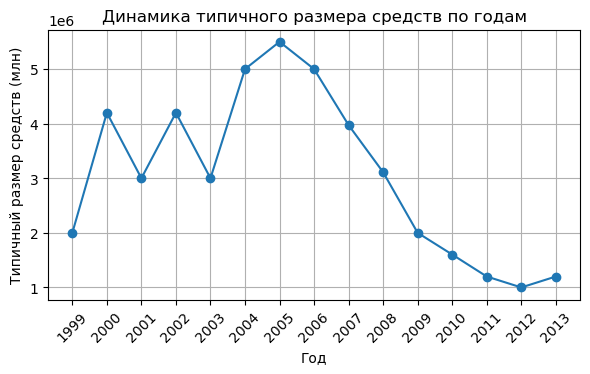

In [19]:
# Построение графика
plt.figure(figsize=(6, 4))
plt.plot(summary_table['year'], summary_table['typical_amount'], marker='o')
plt.title('Динамика типичного размера средств по годам')
plt.xlabel('Год')
plt.ylabel('Типичный размер средств (млн)')
plt.grid()
plt.xticks(summary_table['year'], rotation=45)
plt.tight_layout()
plt.show()

- Максимальный типичный размер собранных средств в рамках одного раунда был в 2005 году и составил 5.5 млн долларов.

В 2013 году:
- Количество раундов финансирования достигло максимума (11,072 раунда).
- Типичный размер средств, выделяемых в рамках одного раунда, увеличился по сравнению с 2012 годом (с 1 млн долларов до 1.2 млн долларов), что указывает на небольшое восстановление после предыдущего снижения.

Анализ графика:
- С 1999 по 2005 год наблюдался рост типичного размера средств, выделяемых на один раунд.
- После 2005 года началось постепенное снижение, которое достигло минимума в 2012 году.
- В 2013 году произошло небольшое увеличение типичного размера финансирования.

Общая тенденция:
- С 1999 года количество раундов финансирования значительно увеличилось, начиная с 76 в 1999 году и достигая 11,042 в 2013 году. Это указывает на растущий интерес к инвестициям и активность на рынке.
- Типичные суммы финансирования колебались в течение рассматриваемого периода. Например, в 2005 году наблюдается пик с суммой 5,500,000, после чего суммы начинают снижаться до уровня ниже 2,000,000 в 2012-2013 годах.

Связь между раундами финансирования и суммами:
- В начале периода (1999-2005) наблюдается рост как типичных сумм, так и количества раундов. Однако после 2005 года, несмотря на продолжение роста количества раундов, типичные суммы начали снижаться.
- С увеличением числа раундов финансирования можно предположить, что рынок стал более насыщенным, что могло привести к снижению типичных сумм. Более высокий объем раундов может означать большее количество малых инвестиций, что в свою очередь снижает среднюю сумму.

Таким образом, рынок финансирования стал более активным с ростом числа раундов. Увеличение количества раундов не всегда связано с ростом типичных сумм финансирования. Несмотря на рост активности на рынке (количество раундов), типичные суммы финансирования не только не росли, но и снижались в последние годы анализа.


### 2.2. Люди и их образование

Заказчик хочет понять, зависит ли полнота сведений о сотрудниках (например, об их образовании) от размера компаний. Оценим, насколько информация об образовании сотрудников полна. 

Для анализа зависимости полноты сведений об образовании сотрудников от размера компаний, необходимо выполнить несколько шагов с использованием предоставленных датасетов: `people.csv`, `education.csv` и `degrees.csv`. 

Проведем предварительный анализ загруженных данных, чтобы понять структуру таблиц. Необходимо обратить внимание на столбцы, которые могут быть использованы для объединения

In [20]:
# Словарь для хранения загруженных датафреймов

dataframes_educ = {
    "degrees": degrees_df,
    "education": education_df,
    "people": people_df
}

In [21]:
# Просмотр первых строк каждого датафрейма
for name, df in dataframes_educ.items():   
    print(f"DataFrame '{name}':")
    print(f"Type:\n{df.head()}\n")
    display(f"{df.info()}\n\n")

DataFrame 'degrees':
Type:
   id object_id degree_type                       subject
0   1    p:6117         MBA                           NaN
1   2    p:6136          BA               English, French
2   3    p:6136          MS            Mass Communication
3   4    p:6005          MS           Internet Technology
4   5    p:5832         BCS  Computer Science, Psychology

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109610 entries, 0 to 109609
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           109610 non-null  int64 
 1   object_id    109610 non-null  object
 2   degree_type  98389 non-null   object
 3   subject      81298 non-null   object
dtypes: int64(1), object(3)
memory usage: 3.3+ MB


'None\n\n'

DataFrame 'education':
Type:
   id  person_id                      instituition graduated_at
0   1       6117                               NaN          NaT
1   2       6136  Washington University, St. Louis   1990-01-01
2   3       6136                 Boston University   1992-01-01
3   4       6005           University of Greenwich   2006-01-01
4   5       5832                   Rice University          NaT

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109610 entries, 0 to 109609
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            109610 non-null  int64         
 1   person_id     109610 non-null  int64         
 2   instituition  109555 non-null  object        
 3   graduated_at  58054 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.3+ MB


'None\n\n'

DataFrame 'people':
Type:
       id  first_name    last_name  company_id network_username
0      10        Mark   Zuckerberg         5.0              NaN
1     100       Peter       Lester        27.0              NaN
2    1000  Dr. Steven  E. Saunders       292.0              NaN
3   10000        Neil        Capel      2526.0              NaN
4  100000         Sue       Pilsch         NaN              NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226709 entries, 0 to 226708
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                226709 non-null  int64  
 1   first_name        226700 non-null  object 
 2   last_name         226705 non-null  object 
 3   company_id        34615 non-null   float64
 4   network_username  38867 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 8.6+ MB


'None\n\n'

Прежде необходимо выполнить преобразование столбца `object_id`, привести идентификаторы к общему виду.

In [22]:
# Преобразование object_id в целые числа
degrees_df['object_id'] = degrees_df[
            'object_id'].str.replace('p:', '').astype(int)

Сначала объединим таблицы people_df и education_df и рассмотрим процент заполненности данных в объединенной таблице.

In [23]:
# Объединение таблиц education_df и people_df
merged_df = pd.merge(
     people_df, education_df, left_on='id', right_on='person_id', how='left', suffixes=(
         '_people', '_education'))

# Процент заполненности информации
merged_fill_rate = round((1 - merged_df.isnull().sum() / len(merged_df)) * 100)
merged_fill_rate

id_people           100.0
first_name          100.0
last_name           100.0
company_id           17.0
network_username     19.0
id_education         41.0
person_id            41.0
instituition         41.0
graduated_at         22.0
dtype: float64

Присоединим таблицу degrees_df и посмотрим, что получим от добавления таблицы, насколько больше станет информации.

In [24]:
# Объединение education с таблицей degrees
merged_df = pd.merge(merged_df, degrees_df, left_on='id_people', right_on='object_id', how='left')

# Процент заполненности информации
merged_fill_rate = round((1 - merged_df.isnull().sum() / len(merged_df)) * 100)
merged_fill_rate

id_people           100.0
first_name          100.0
last_name           100.0
company_id           19.0
network_username     22.0
id_education         57.0
person_id            57.0
instituition         57.0
graduated_at         31.0
id                   57.0
object_id            57.0
degree_type          51.0
subject              42.0
dtype: float64

Для получения информации по образованию мы можем использовать столбцы `instituition`, `graduated_at`, `degree_type`. Так как, просле присоединения таблицы `degrees` информативность этих столбцов возрастает, можно сделать вывод что присоединение целесообразно. 

Добавим новый столбец с необходимой информацией о наличии образования. '1' указывает на наличие значения (то есть образование есть), а '0' — на его отсутствие (пропуск). Используем столбец `instituition`.

In [25]:
# Добавляем новый столбец 'education' с использованием .loc
merged_df['education'] = merged_df['instituition'].notnull().astype(int)
merged_df.head()

,id_people,first_name,last_name,company_id,network_username,id_education,person_id,instituition,graduated_at,id,object_id,degree_type,subject,education
0,10,Mark,Zuckerberg,5.0,NaN,2415.0,10.0,Harvard University,NaT,2415.0,10.0,NaN,Computer Science,1
1,100,Peter,Lester,27.0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,0
2,1000,Dr. Steven,E. Saunders,292.0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,0
3,10000,Neil,Capel,2526.0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,0
4,100000,Sue,Pilsch,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,0


Посчитаем для каждой компании:
- общее количество сотрудников;
- количество сотрудников без образования;
- долю сотрудников без образования.

In [26]:
# Создание сводной таблицы
summary_table = merged_df.groupby('company_id').agg(
    employee_count=('id_people', 'count'),  # Подсчет количества сотрудников
    no_education_count=('education', lambda x: (x == 0).sum()),  # Подсчет сотрудников без образования
).reset_index()

# Добавление доли сотрудников без образования
summary_table['no_education_ratio'] = summary_table['no_education_count'] / summary_table['employee_count']

# Вывод сводной таблицы
display(summary_table)


,company_id,employee_count,no_education_count,no_education_ratio
0,1.0,5,1,0.200000
1,2.0,1,0,0.000000
2,3.0,9,1,0.111111
3,4.0,28,1,0.035714
4,5.0,138,16,0.115942
...,...,...,...,...
22917,285897.0,2,0,0.000000
22918,285953.0,1,1,1.000000
22919,285972.0,2,1,0.500000
22920,285996.0,1,0,0.000000


Посмотрим на распределение людей по компаниям, чтобы оценить , на какие группы разделять компании.

In [27]:
# Посмотрим на распределение людей по компаниям
company_distribution = summary_table['employee_count'].value_counts()
company_distribution


employee_count
1      14150
4       3198
2       1738
9        909
5        703
       ...  
320        1
112        1
83         1
40         1
58         1
Name: count, Length: 82, dtype: int64

In [28]:
# Посмотрим на распределение людей по компаниям
summary_table.describe()

,company_id,employee_count,no_education_count,no_education_ratio
count,22922.000000,22922.000000,22922.000000,22922.000000
mean,102688.472646,3.091746,0.706701,0.452306
std,84842.926930,7.948286,1.227940,0.477889
min,1.000000,1.000000,0.000000,0.000000
25%,28844.500000,1.000000,0.000000,0.000000
50%,70878.500000,1.000000,1.000000,0.142857
75%,174083.500000,4.000000,1.000000,1.000000
max,286091.000000,722.000000,76.000000,1.000000


Сгруппируем таблицу по количеству сотрудников в одной компании. Границы групп выбраны следующим образом:
- 1-5 сотрудников
- 5-10 сотрудников
- 10-20 сотрудников
- 20-50 сотрудников
- 50-100 сотрудников
- Более 100 сотрудников

Эти границы выбраны для более детального анализа малых и крупных компаний. Также оценим среднюю долю сотрудников без информации об образовании в каждой группе. 

In [29]:
# Определение границ групп
bins = [0, 5, 10, 20, 50, 100, float('inf')]
labels = ['1-5', '6-10', '11-20', '21-50', '51-100', 'Более 100']

# Создание новой колонки с группами
summary_table['group'] = pd.cut(summary_table['employee_count'], bins=bins, labels=labels)

# Группировка по новым категориям и расчет необходимых метрик
grouped = summary_table.groupby('group', observed=False).agg(
    total_employees=('employee_count', 'sum'),
    total_companies=('company_id', 'count'),
    avg_no_education_ratio=('no_education_ratio', lambda x: (x.mean() * 100).round(0))
).reset_index()

# Вывод результата
print(grouped)

       group  total_employees  total_companies  avg_no_education_ratio
0        1-5            35340            20258                    50.0
1       6-10            14412             1722                    12.0
2      11-20             9884              673                    11.0
3      21-50             6630              229                     8.0
4     51-100             1821               27                     7.0
5  Более 100             2782               13                     9.0


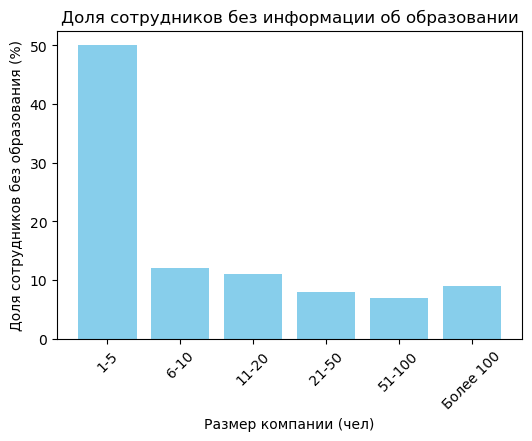

In [30]:
# Построение гистограммы
plt.figure(figsize=(6, 4))
plt.bar(grouped['group'], grouped['avg_no_education_ratio'], color='skyblue')
plt.title('Доля сотрудников без информации об образовании')
plt.xlabel('Размер компании (чел)')
plt.ylabel('Доля сотрудников без образования (%)')
plt.xticks(rotation=45)
    
plt.show()

В результате можно заключить, что в малых компаниях (с численностью от 1 до 5 сотрудников) доля работников без данных об образовании значительно выше, чем в средних и крупных организациях. 

Это свидетельствует о том, что полнота сведений о сотрудниках зависит от размера компании, по крайней мере, в контексте уровня образования. Чем больше компания, тем большее количество сотрудников имеет информацию об их образовании.

### 2.3. Объединять или не объединять — вот в чём вопрос

* Установим, подходит ли для объединения данных столбец `network_username`, который встречается в нескольких датасетах. Нам необходимо понимать, дублируется ли для разных датасетов информация в столбцах с таким названием, и если да — то насколько часто.

* Оценим, можно ли использовать столбцы с именем `network_username` для объединения данных.

Для оценки возможности использования столбца network_username для объединения данных из различных датасетов, необходимо проанализировать его сожержание, присутствие и частоту значений в каждом из датасетов. Используем созданый ранее словарь

In [31]:
# Функция для получения уникальных значений в столбце network_username
def unique_network_usernames(dataframes):
    unique_usernames = {}
    
    for name, df in dataframes.items():
        if 'network_username' in df.columns:
            unique_usernames[name] = df['network_username'].unique()
        else:
            unique_usernames[name] = None
            
    return unique_usernames

# Получаем уникальные значения
unique_usernames_result = unique_network_usernames(dataframes)

# Выводим результат
for dataset, usernames in unique_usernames_result.items():
    print(f"{dataset}: {usernames}")

acquisition: None
company_and_rounds: ['BachelrWetpaint' nan 'Hostnine' ... 'networkzend' 'pPhotonet' 'Photonet']
degrees: None
education: None
fund: [nan 'greylockvc' 'imi_vc' ... 'CalSTRS' 'haystack_fund' 'fbFund']
investment: None
people: [nan 'jobsbostontech' 'fbroulette' ... 'itechsocialnet' 'socialnethubs'
 'esocialnetlike']


In [32]:
# Словарь для хранения частоты значений
network_username_counts = {}

# Подсчет значений в столбце network_username для каждого датасета
for name, df in dataframes.items():
    if 'network_username' in df.columns:
        counts = df['network_username'].value_counts()
        network_username_counts[name] = counts
    else:
        network_username_counts[name] = None

network_username_counts

{'acquisition': None,
 'company_and_rounds': network_username
 Goodman_UK      20
 IndiaMART       17
 mobivery        15
 tyropayments    15
 AviirLabs       14
                 ..
 GnRTech          1
 appcamelot       1
 furnillion       1
 pixelhose        1
 treebetty        1
 Name: count, Length: 79571, dtype: int64,
 'degrees': None,
 'education': None,
 'fund': network_username
 SVB_Financial      4
 GrowthWorks        4
 OsageVC            3
 rwe_ag             3
 upfrontvc          3
                   ..
 seraphimcapital    1
 VolvoVC            1
 eedwards           1
 dshen              1
 fbFund             1
 Name: count, Length: 2098, dtype: int64,
 'investment': None,
 'people': network_username
 iWatchLife         6
 chrislogan         5
 ConnectAndSell     4
 firstscribe        4
 bubblehubdotcom    3
                   ..
 jasonkneen         1
 billymauro         1
 manju_s7           1
 bioveiga           1
 esocialnetlike     1
 Name: count, Length: 38421, dtype: 

Для оценки возможности использования столбца network_username для объединения данных из трех таблиц (`company_and_rounds_df`, `people_df`, `fund_df`), необходимо проанализировать количество пересечений значений в этом столбце. 

Найдем уникальные имена пользователей из таблиц и посмотрим на их пересечение

In [33]:
# Получение уникальных значений из столбца network_username
company_usernames = set(company_and_rounds_df['network_username'].dropna())
people_usernames = set(people_df['network_username'].dropna())
fund_usernames = set(fund_df['network_username'].dropna())

In [34]:
# Нахождение пересечений
intersection_company_people = company_usernames.intersection(people_usernames)
intersection_people_fund = people_usernames.intersection(fund_usernames)
intersection_company_fund = company_usernames.intersection(fund_usernames)

In [35]:
# Общее пересечение всех трех таблиц
intersection_all = company_usernames.intersection(people_usernames).intersection(fund_usernames)

# Вывод результатов
print(f'Пересечения между company_and_rounds и people: {len(intersection_company_people)}')
print(f'Пересечения между people и fund: {len(intersection_people_fund)}')
print(f'Пересечения между company_and_rounds и fund: {len(intersection_company_fund)}')
print(f'Общее пересечение всех трех таблиц: {len(intersection_all)}')

Пересечения между company_and_rounds и people: 2199
Пересечения между people и fund: 79
Пересечения между company_and_rounds и fund: 70
Общее пересечение всех трех таблиц: 7


Столбец `network_username` присутствует в следующих датасетах: 
- `fund`: содержит 2098 уникальных значений. 
- `people`: содержит 38421 уникальное значение. 
- `company_and_rounds`: содержит 79571 уникальное значение.
В остальных датасетах (`acquisition`, `degrees`, `education`, `investment`) столбец network_username отсутствует.

На основании проведенного анализа были получены следующие результаты по пересечениям:
- Пересечения между company_and_rounds и people: 2199
- Пересечения между people и fund: 79
- Пересечения между company_and_rounds и fund: 70
- Общее пересечение всех трех таблиц: 7

С учетом того, что столбец `network_username` присутствует только в трёх из семи датасетов и имеет разное количество уникальных значений, его использование для объединения данных будет ограничено. 

Объединение возможно только между датасетами `company_and_rounds` и `people`: значительное количество совпадений (2199) указывает на то, что данные в этих двух таблицах имеют много общих значений в столбце `network_username`. Это может свидетельствовать о том, что обе таблицы содержат информацию о схожих участниках или компаниях, что делает их хорошими кандидатами для объединения.

Однако, учитывая, что количество пересечений  значений в остальных датасетах значительно различается это может привести к неэффективному объединению. 


### 2.4. Проблемный датасет и причина возникновения пропусков

Во время собственного анализа данных у заказчика больше всего вопросов возникло к датасету `company_and_rounds.csv`. В нём много пропусков как раз в информации о раундах, которая заказчику важна. Хотя информация об общем объёме финансирования по раундам присутствует в других датасетах, заказчик считает данные `company_and_rounds.csv` о размере средств наиболее верными.

* Приведем данные в вид, который позволяет проводить анализ в разрезе отдельных компаний. По гипотезе заказчика данные по компаниям из этой таблицы раньше хранились иначе, более удобным для исследования образом.

* Максимальным образом сохраняя данные, сохранив их связность и исключив возможные возникающие при этом ошибки, подготовим данные так, чтобы удобно было отобрать компании по параметрам и рассчитать показатели из расчёта на одну компанию.

Для анализа датасета `company_and_rounds.csv` и устранения проблем с пропусками, необходимо выполнить несколько шагов по подготовке данных. Основная цель — привести данные в удобный формат для анализа по отдельным компаниям, сохраняя при этом их связность и минимизируя ошибки.

In [36]:
# Анализируем структуру и содержимое датасета
structure = company_and_rounds_df.info()
head = company_and_rounds_df.head()

structure, head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217774 entries, 0 to 217773
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   company_id           217472 non-null  float64       
 1   name                 217471 non-null  object        
 2   category_code        143886 non-null  object        
 3   status               217472 non-null  object        
 4   founded_at           109956 non-null  object        
 5   closed_at            3449 non-null    object        
 6   domain               147159 non-null  object        
 7   network_username     95534 non-null   object        
 8   country_code         108607 non-null  object        
 9   investment_rounds    217472 non-null  float64       
 10  funding_rounds       217472 non-null  float64       
 11  funding_total        217472 non-null  float64       
 12  milestones           217472 non-null  float64       
 13  funding_round_

(None,
    company_id      name category_code     status  founded_at closed_at  \
 0         1.0  Wetpaint           web  operating  2005-10-17       NaN   
 1         1.0  Wetpaint           web  operating  2005-10-17       NaN   
 2         1.0  Wetpaint           web  operating  2005-10-17       NaN   
 3        10.0   Flektor   games_video   acquired         NaN       NaN   
 4       100.0     There   games_video   acquired         NaN       NaN   
 
              domain network_username country_code  investment_rounds  ...  \
 0  wetpaint-inc.com  BachelrWetpaint          USA                0.0  ...   
 1  wetpaint-inc.com  BachelrWetpaint          USA                0.0  ...   
 2  wetpaint-inc.com  BachelrWetpaint          USA                0.0  ...   
 3       flektor.com              NaN          USA                0.0  ...   
 4         there.com              NaN          USA                0.0  ...   
 
    funding_round_id  company_id_round  funded_at  funding_round_type  

Датасет содержит 23 столбца, среди которых есть информация о компании, раундах финансирования и других параметрах. Важно отметить, что в датасете пропусков, особенно в информации о раундах финансирования. Возможно, датасет состоит из двух разных таблиц - `Информация о компании` и `Информация о раундах финансирования`.

Для анализа в разрезе отдельных компаний  разделим имеющуюся таблицу на две: с информацией по компаниям, с информацией по раундам, выделим нудные нам столбцы. Первая таблица `company`
- `company_id` — идентификатор компании.
- `name` — название компании.
- `category code` — категория области деятельности компании.
- `status` — статус компании.
- `founded at` — дата инвестирования.
- `closed at` — дата закрытия компании.
- `domain` — официальный сайт компании.
- `network username` — ник компании в сети.
- `country code` — код страны компании.
- `investment rounds` — число инвестиционных раундов.
- `funding rounds` — число раундов финансирования.
- `funding total` — сумма финансирования.
- `milestones` — вехи финансирования.
- `raised amount` — сумма финансирования

Вторая таблица `rounds`
- `funding round id` — идентификатор этапа финансирования.
- `company id` — идентификатор компании.
- `funded at` — дата финансирования.
- `funding round type` — тип финансирования.
- `raised amoun`t — сумма финансирования.
- `pre money valuation` — предварительная денежная оценка.
- `participants` — число участников.
- `is first round` — является ли раунд первым.
- `is last round` — является раунд последним.

Создадим необходимые таблицы, удалив все дубликаты 

In [37]:
# Создаем таблицу company с нужными столбцами
company_columns = [
    'company_id',
    'name',
    'category_code',
    'status',
    'founded_at',
    'closed_at',
    'domain',
    'network_username',
    'country_code',
    'investment_rounds',
    'funding_rounds',
    'funding_total',
    'milestones',
    'raised_amount'
]

company_df = company_and_rounds_df[company_columns].drop_duplicates()
company_df.head()

,company_id,name,category_code,status,founded_at,closed_at,domain,network_username,country_code,investment_rounds,funding_rounds,funding_total,milestones,raised_amount
0,1.0,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,BachelrWetpaint,USA,0.0,3.0,39750000.0,5.0,5250000.0
1,1.0,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,BachelrWetpaint,USA,0.0,3.0,39750000.0,5.0,9500000.0
2,1.0,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,BachelrWetpaint,USA,0.0,3.0,39750000.0,5.0,25000000.0
3,10.0,Flektor,games_video,acquired,NaN,NaN,flektor.com,NaN,USA,0.0,0.0,0.0,0.0,NaN
4,100.0,There,games_video,acquired,NaN,NaN,there.com,NaN,USA,0.0,0.0,0.0,4.0,NaN


In [38]:
# Создаем таблицу rounds с нужными столбцами
rounds_columns = [
    'funding_round_id',
    'company_id_round',
    'funded_at',
    'funding_round_type',
    'raised_amount',
    'pre_money_valuation',
    'participants',
    'is_first_round',
    'is_last_round'
]

rounds_df = company_and_rounds_df[rounds_columns].drop_duplicates()
rounds_df

,funding_round_id,company_id_round,funded_at,funding_round_type,raised_amount,pre_money_valuation,participants,is_first_round,is_last_round
0,888.0,1.0,2005-10-01,series-a,5250000.0,0.0,2.0,0.0,1.0
1,889.0,1.0,2007-01-01,series-b,9500000.0,0.0,3.0,0.0,0.0
2,2312.0,1.0,2008-05-19,series-c+,25000000.0,0.0,4.0,1.0,0.0
3,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
15,1644.0,1001.0,2008-02-26,series-a,5000000.0,0.0,3.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
217769,56454.0,282847.0,2011-01-31,other,5500000.0,0.0,0.0,1.0,1.0
217770,56542.0,55477.0,2011-01-13,venture,10633300.0,0.0,0.0,0.0,1.0
217771,56543.0,55477.0,2012-05-31,venture,2125720.0,0.0,0.0,1.0,0.0
217772,56928.0,283492.0,2013-12-03,venture,3602480.0,0.0,5.0,1.0,1.0


В результате обработки данных из файла company_and_rounds.csv были созданы две таблицы: company_df и rounds_df. Проведем анализ таблиц на наличие пропусков в данных 

In [39]:
# Проверка на пропуски
missing_values_company = company_df.isnull().sum()
# Вычисление доли пропусков в процентах
missing_percentage_company = (missing_values_company / len(company_df)) * 100

display("Пропуски в company_df:")
display(missing_values_company[missing_values_company > 0])
display("Доля пропусков в company_df (%):")
display(missing_percentage_company[missing_values_company > 0])

'Пропуски в company_df:'

company_id              144
name                    145
category_code         73711
status                  144
founded_at           107536
closed_at            212802
domain                70437
network_username     121758
country_code         108973
investment_rounds       144
funding_rounds          144
funding_total           144
milestones              144
raised_amount        164846
dtype: int64

'Доля пропусков в company_df (%):'

company_id            0.066611
name                  0.067073
category_code        34.096733
status                0.066611
founded_at           49.743272
closed_at            98.436503
domain               32.582269
network_username     56.321988
country_code         50.407990
investment_rounds     0.066611
funding_rounds        0.066611
funding_total         0.066611
milestones            0.066611
raised_amount        76.253342
dtype: float64

Общая информация о пропусках
В таблице присутствуют следующие пропуски:
category_code: 36.68%
founded_at: 52.66%
closed_at: 96.97%
domain: 35.00%
network_username:57.98%
country_code: 54.28%

Пропуски в других столбцах минимальны, всего по одному. Их можно удалить 
Для столбцов с высокой степенью неопределенности можно использовать значения по умолчанию (например, "не указано" для category_code).

Возможные причины пропусков
- category_code: Высокая степень неопределенности в классификации компаний может приводить к отсутствию данных.
- founded_at: Некоторые компании могут быть новыми или не зарегистрированными, что затрудняет указание даты основания.
- closed_at: Высокий процент отсутствующих данных может указывать на то, что многие компании все еще активны и не имеют даты закрытия.
- domain: Некоторые компании могут не иметь веб-сайта или он может быть недоступен.
- network_username: Отсутствие представительства в социальных сетях также может объяснять высокий уровень пропусков.
- country_code: Некоторые компании могут быть международными или не иметь четкой привязки к стране.

In [40]:
# Проверка на пропуски
missing_values_rounds = rounds_df.isnull().sum()
# Вычисление доли пропусков в процентах
missing_percentage_rounds = (missing_values_rounds / len(rounds_df)) * 100

display("Пропуски в rounds_df:")
display(missing_values_rounds[missing_values_rounds > 0])
display("Доля пропусков в rounds_df (%):")
display(missing_percentage_rounds[missing_values_rounds > 0])

'Пропуски в rounds_df:'

funding_round_id         1
company_id_round         1
funded_at              249
funding_round_type       1
raised_amount            1
pre_money_valuation      1
participants             1
is_first_round           1
is_last_round            1
dtype: int64

'Доля пропусков в rounds_df (%):'

funding_round_id       0.001889
company_id_round       0.001889
funded_at              0.470442
funding_round_type     0.001889
raised_amount          0.001889
pre_money_valuation    0.001889
participants           0.001889
is_first_round         0.001889
is_last_round          0.001889
dtype: float64

Доля пропусков менее 1%, их можно удалить

Датасет приведен в вид, который позволяет проводить анализ в разрезе отдельных компаний.


## Шаг 3. Исследовательский анализ объединённых таблиц



### 3.1. Объединение данных

Объединим данные для ответа на вопросы заказчика, которые касаются интересующих его компаний.

В качестве основы для объединённой таблицы возьмем данные из обработанного датасета `company_and_rounds.csv` — выберем только те компании, у которых указаны значения `funding_rounds` или `investment_rounds` больше нуля, и те, у которых в колонке `status` указано `acquired`.


Создадим новый датасет `company_df` для дальнейшей работы.

In [41]:
company_df = company_df[
    ( (company_df['funding_rounds'] > 0) | (company_df['investment_rounds'] > 0) ) | 
    (company_df['status'] == 'acquired')]
company_df.head()

,company_id,name,category_code,status,founded_at,closed_at,domain,network_username,country_code,investment_rounds,funding_rounds,funding_total,milestones,raised_amount
0,1.0,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,BachelrWetpaint,USA,0.0,3.0,39750000.0,5.0,5250000.0
1,1.0,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,BachelrWetpaint,USA,0.0,3.0,39750000.0,5.0,9500000.0
2,1.0,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,BachelrWetpaint,USA,0.0,3.0,39750000.0,5.0,25000000.0
3,10.0,Flektor,games_video,acquired,NaN,NaN,flektor.com,NaN,USA,0.0,0.0,0.0,0.0,NaN
4,100.0,There,games_video,acquired,NaN,NaN,there.com,NaN,USA,0.0,0.0,0.0,4.0,NaN


In [42]:
company_df.columns.tolist()

['company_id',
 'name',
 'category_code',
 'status',
 'founded_at',
 'closed_at',
 'domain',
 'network_username',
 'country_code',
 'investment_rounds',
 'funding_rounds',
 'funding_total',
 'milestones',
 'raised_amount']


### 3.2. Анализ выбросов

Заказчика интересует обычный для рассматриваемого периода размер средств, который предоставлялся компаниям. По предобработанному столбцу `funding_total` оценим, какой размер общего финансирования для одной компании будет типичным, а какой — выбивающимся.


In [43]:
company_df = company_df[company_df['funding_total'] != 0]
company_df.shape

(47359, 14)

Проведем вычисления для нахождения обычного для рассматриваемого периода размера средств, предоставляемого компаниям. Получим статистические показатели и вычислим выбивающиеся значения

Для начала, визуализируем не отфильтрованные данные, посмотрим на распредение

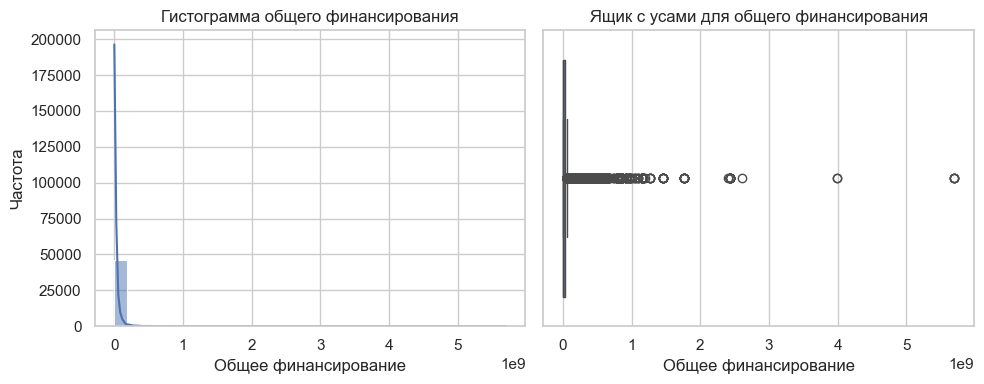

In [44]:
#Настройка визуализации
sns.set(style='whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

#Гистограмма
sns.histplot(company_df['funding_total'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Гистограмма общего финансирования')
axes[0].set_xlabel('Общее финансирование')
axes[0].set_ylabel('Частота')

#Ящик с усами
sns.boxplot(x=company_df['funding_total'], ax=axes[1])
axes[1].set_title('Ящик с усами для общего финансирования')
axes[1].set_xlabel('Общее финансирование')

plt.tight_layout()
plt.show()

На гистограмме распределение данных сильно смещено влево, что говорит о наличии большого количества компаний с низким уровнем общего финансирования.
Видно, что большинство значений сосредоточено в диапазоне близком к нулю, а хвост распределения тянется далеко вправо, указывая на редкие, но очень высокие значения.

У ящика с усами большая часть данных находится в нижней части диапазона значений, что подтверждает выводы из гистограммы.
Наблюдается множество выбросов, которые значительно превышают верхнюю границу усов. Эти выбросы представляют компании с крайне высоким уровнем финансирования.

In [45]:
#Вычисление квартилей
Q1 = company_df['funding_total'].quantile(0.25)
Q3 = company_df['funding_total'].quantile(0.75)
#Вычисление межквартильного размаха
IQR = Q3 - Q1
#Определение границ для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Выявление выбросов
outliers = company_df[(company_df[
          'funding_total'] < lower_bound) | (company_df[
                     'funding_total'] > upper_bound)]
outliers.shape

(5146, 14)

Приведем наиболее типичный размер общего финансирования для одной компании после удаления выбросов

In [46]:
# Удаление выбросов из основного DataFrame
filtered_df = company_df[(
          company_df['funding_total'] >= lower_bound) & (company_df[
                'funding_total'] <= upper_bound)]
filtered_df.shape

(42213, 14)

Сделаем визуализацию распределение данных в столбце funding_total

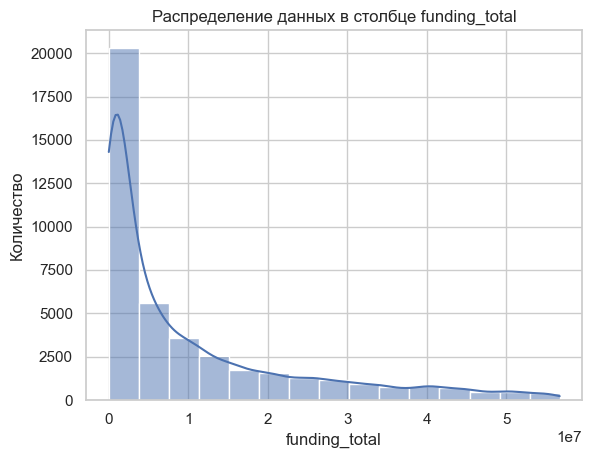

In [47]:
# Построим распределение данных для столбца `score`
sns.histplot(data=filtered_df, x='funding_total', bins=15, kde=True)

# Подписываем и отображаем график
plt.title('Распределение данных в столбце funding_total')
plt.ylabel('Количество')
plt.show()

Посмотрим на статистические показатели размера общего финансирования

In [48]:
#Метод describe
statistics = filtered_df['funding_total'].describe()

# Округляем результаты до 2 знаков после запятой
rounded_statistics = statistics.round(2)

statistics.describe()

count    8.000000e+00
mean     1.250199e+07
std      1.882163e+07
min      2.910000e+02
25%      6.855532e+05
50%      7.199296e+06
75%      1.360611e+07
max      5.670000e+07
Name: funding_total, dtype: float64

Основные статистические показатели:
- Среднее значение общего финансирования составляет порядка 4.59 млн.
- Стандартное отклонение указывает на разброс значений вокруг среднего. В данном случае, большое стандартное отклонение (более 6 миллионов) говорит о том, что размеры финансирования сильно варьируются между компаниями.
- Минимальное значение финансирования. Это означает, что некоторые компании получили очень небольшие суммы, близкие к нулю.
- 25% (1-й квартиль): 0.417 млн. Значение, ниже которого находится 25% наблюдений. Это говорит о том, что 25% компаний получили финансирование менее 0.417 млн.
- Медианное значение показывает, что половина компаний получила финансирование менее 1.8 миллиона и более половины — больше этой суммы.
- 75% (3-й квартиль): 6.4 млн Значение, ниже которого находится 75% наблюдений. Это указывает на то, что 75% компаний получили финансирование менее 6.4 миллиона.
- Максимальное значение финансирования 26.75млн, которое получала компания. Это значение указывает на наличие компаний, которые получили значительно больше средств по сравнению с остальными.


### 3.3. Куплены забесплатно?

* Исследуем компании, которые были проданы за ноль или за один доллар, и при этом известно, что у них был ненулевой общий объём финансирования.

In [49]:
company_df.head()

,company_id,name,category_code,status,founded_at,closed_at,domain,network_username,country_code,investment_rounds,funding_rounds,funding_total,milestones,raised_amount
0,1.0,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,BachelrWetpaint,USA,0.0,3.0,39750000.0,5.0,5250000.0
1,1.0,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,BachelrWetpaint,USA,0.0,3.0,39750000.0,5.0,9500000.0
2,1.0,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,BachelrWetpaint,USA,0.0,3.0,39750000.0,5.0,25000000.0
15,1001.0,FriendFeed,web,acquired,2007-10-01,NaN,friendfeed.com,friendfeed,USA,0.0,1.0,5000000.0,3.0,5000000.0
21,10015.0,Fitbit,health,operating,2007-10-01,NaN,fitbit.com,fitbit,USA,0.0,5.0,68069200.0,0.0,2000000.0


Выберем компании, которые были проданы за ноль или за один доллар, и при этом известно, что у них был ненулевой общий объём финансирования. (Объем финансирования по столбцу `funding_total` очистили от нулей ранее ) 

In [50]:
# Применение фильтра
filtered_amount_df = company_df[company_df['raised_amount'] <= 1]

filtered_amount_df.shape

(1508, 14)

Посмотрим на границы выбросов и вычислим какому перцентилю они будут соответствовать.

In [51]:
#Вычисление квартилей
Q1 = filtered_amount_df['funding_total'].quantile(0.25)
Q3 = filtered_amount_df['funding_total'].quantile(0.75)
#Вычисление межквартильного размаха
IQR = Q3 - Q1
#Определение границ для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [52]:
# Рассчет процентилей для границ
lower_percentile = (filtered_amount_df['funding_total'] < lower_bound).mean() * 100
upper_percentile = round((filtered_amount_df['funding_total'] > upper_bound).mean() * 100)
#Выведем результат
display(f"Нижняя граница {lower_bound}, процентиль: {lower_percentile}")
display(f"Верхняя граница {upper_bound}, процентиль: {upper_percentile}")


'Нижняя граница -19674575.0, процентиль: 0.0'

'Верхняя граница 35457625.0, процентиль: 11'

Замена границ выбросов на значения, рассчитанные по процентилям, может быть оправдана в следующих случаях:
- Снижение влияния аномалий: Использование процентилей может помочь избежать искажений, связанных с экстремальными значениями.
- Устойчивость к выбросам: Процентильные методы менее чувствительны к выбросам по сравнению с традиционными методами.
Однако следует учитывать, что устранение значений может привести к потере важных инсайтов о финансировании компаний.

На основе полученных данных можно сделать следующие выводы: Замена нижней и верхней границы выбросов на значения, рассчитанные по процентилям, является обоснованной. Это позволит исключить аномально высокие или низкие значения, которые могут искажать анализ.


### 3.4. Цены стартапов по категориям

Категории стартапов с наибольшими ценами и значительным разбросом цен могут быть наиболее привлекательными для крупных инвесторов, которые готовы к высоким рискам ради потенциально больших доходов. Среди категорий стартапов выделим категории стартапов, характеризующиеся:

* наибольшими ценами;
* и наибольшим разбросом цен за стартап.

Для анализа категорий стартапов с наибольшими ценами и значительным разбросом цен, рассмотрим данные о стартапах, используя столбец `raised_amount`. Это позволяет выявить наиболее привлекательные для инвесторов категории, готовых к высоким рискам ради потенциально больших доходов.

Перед анализом необходимо убедиться, что данные корректны и не содержат выбросов. Для этого можно использовать метод межквартильного размаха (IQR) для фильтрации выбросов в столбце raised_amount.

In [53]:
# Фильтрация выбросов
Q1 = company_df['raised_amount'].quantile(0.25)
Q3 = company_df['raised_amount'].quantile(0.75)
IQR = Q3 - Q1
filtered_df = company_df[(
              company_df['raised_amount'] >= (
                       Q1 - 1.5 * IQR)) & (company_df[
                           'raised_amount'] <= (Q3 + 1.5 * IQR))]
filtered_df.shape

(42556, 14)

Для нахождения категорий с наибольшими ценами можно использовать медиану. Медиана является более устойчивой к выбросам, чем среднее значение, что позволяет лучше отражать "типичную" цену стартапов в каждой категории.

Разброс цен можно оценить с помощью стандартного отклонения (std). Стандартное отклонение показывает, насколько сильно цены варьируются в пределах категории, что помогает выявить категории с высоким риском и высокой потенциальной доходностью

Метод var() вычислит дисперсию для каждой группы. Дисперсия является мерой разброса значений относительно их среднего. В данном контексте это даст представление о том, насколько сильно различаются суммы, собранные в каждой категории, что может быть полезно для анализа финансовых данных или оценки рисков.

In [54]:
# Группировка данных
grouped = filtered_df.groupby(
             'category_code')['raised_amount'].agg(['median', 'std', 'var'])
grouped.head()

,median,std,var
category_code,,,
advertising,2000000.0,4.096707e+06,1.678301e+13
analytics,1500000.0,3.891924e+06,1.514707e+13
automotive,1121450.0,3.870294e+06,1.497917e+13
biotech,2500000.0,4.564104e+06,2.083104e+13
cleantech,3487465.0,4.896013e+06,2.397094e+13


Теперь можем составить топ по категориям

In [55]:
# Получение топовых категорий по средней цене
top_mean = grouped.nlargest(5, 'median')
top_mean

,median,std,var
category_code,,,
semiconductor,6000000.0,5.108332e+06,2.609505e+13
nanotech,3639120.0,4.358313e+06,1.899489e+13
cleantech,3487465.0,4.896013e+06,2.397094e+13
medical,3000000.0,4.542094e+06,2.063062e+13
network_hosting,3000000.0,4.861377e+06,2.363299e+13


In [56]:
# Получение топовых категорий по разбросу цен
top_std = grouped.nlargest(5, 'std')
top_std

,median,std,var
category_code,,,
semiconductor,6000000.0,5.108332e+06,2.609505e+13
pets,881250.0,5.091414e+06,2.592250e+13
cleantech,3487465.0,4.896013e+06,2.397094e+13
network_hosting,3000000.0,4.861377e+06,2.363299e+13
public_relations,2080000.0,4.567725e+06,2.086411e+13


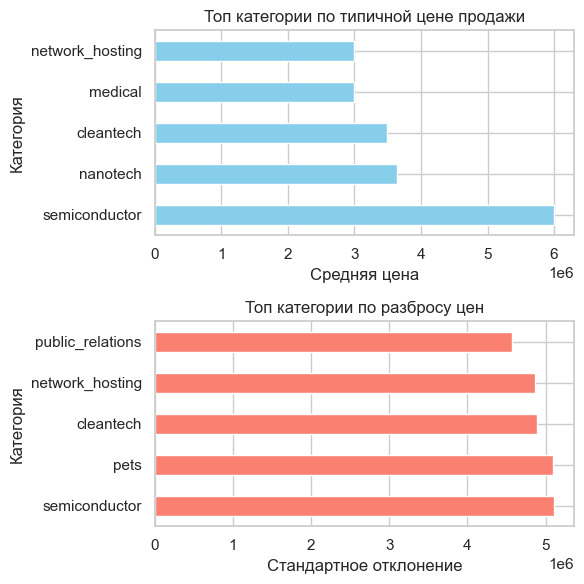

In [57]:
# Визуализация
fig, ax = plt.subplots(2, 1, figsize=(6, 6))

# График для средней цены
top_mean['median'].plot(kind='barh', ax=ax[0], color='skyblue')  
ax[0].set_title('Топ категории по типичной цене продажи')
ax[0].set_xlabel('Средняя цена')  
ax[0].set_ylabel('Категория')

# График для разброса цен
top_std['std'].plot(kind='barh', ax=ax[1], color='salmon')  
ax[1].set_title('Топ категории по разбросу цен')
ax[1].set_xlabel('Стандартное отклонение') 
ax[1].set_ylabel('Категория')


plt.tight_layout()
plt.show()

На основе предоставленных данных, топовые категории по средней цене выглядят следующим образом:
- Полупроводники 6 млн.
- Нанотехнологии 3.6 млн.
- Чистые технологии	3.5 млн.
- Медицина	3 млн.
- Хостинг сетей	3 млн.

Топовые категории по стандартному отклонению выглядят следующим образом:
- Полупроводники 5.1млн.	
- Домашние животные	5,1 млн.
- Чистые технологии	4,9 млн.
- Хостинг сетей 4,9 млн.
- Связи с общественностью	4,6 млн.

Наиболее высокие типичные цены наблюдаются в категории полупроводников, что может свидетельствовать о высоких затратах на исследования и разработки в этой области. Наибольший разброс наблюдается также в категории полупроводников, что может указывать на значительные колебания в ценах на компоненты или технологии в этой области.

 
Таким образом, анализ категорий стартапов по критериям максимальной суммы привлеченных средств и разброса цен позволяет выделить наиболее перспективные направления для инвестиций.


### 3.5. Сколько раундов продержится стартап перед покупкой

* Необходимо проанализировать столбец `funding_rounds`. Исследуем значения столбца. Заказчика интересует типичное значение количества раундов для каждого возможного статуса стартапа.

In [58]:
# Анализ значений столбца funding_rounds
funding_rounds_analysis = company_df['funding_rounds'].describe()
 # Получение уникальных статусов стартапов
unique_statuses = company_df['status'].unique()

funding_rounds_analysis, unique_statuses

(count    47359.000000
 mean         2.601998
 std          1.903801
 min          1.000000
 25%          1.000000
 50%          2.000000
 75%          3.000000
 max         15.000000
 Name: funding_rounds, dtype: float64,
 array(['operating', 'acquired', 'ipo', 'closed'], dtype=object))

Удалим дубликаты по набору компания - количество раундов. И отфильтруем компании, у которых был хотя бы один раунд финансирования.

In [59]:
# Фильтрация компаний с хотя бы одним раундом финансирования
filtered_rounds_df = company_df[company_df['funding_rounds'] > 0]
filtered_rounds_df.shape

(47359, 14)

In [60]:
# Удаление дубликатов по 'company  ID' и 'funding  rounds'
deduplicated_df_df = filtered_df.drop_duplicates(subset=['company_id', 'funding_rounds'])

deduplicated_df_df.shape

(26320, 14)

Вычисляем среднее значение для каждой группы (каждого статуса). Это даст нам среднее количество раундов финансирования для каждой категории статуса.

In [61]:
# Группировка по статусу и вычисление среднего значения
typical_funding_rounds = deduplicated_df_df.groupby(
                 'status')['funding_rounds'].mean().reset_index()
# Округление значений в столбце funding_rounds
typical_funding_rounds['funding_rounds'] = typical_funding_rounds['funding_rounds'].round()
# Сортировка по возрастанию
typical_funding_rounds = typical_funding_rounds.sort_values(
                 by='funding_rounds', ascending=False)

typical_funding_rounds

,status,funding_rounds
2,ipo,3.0
0,acquired,2.0
3,operating,2.0
1,closed,1.0


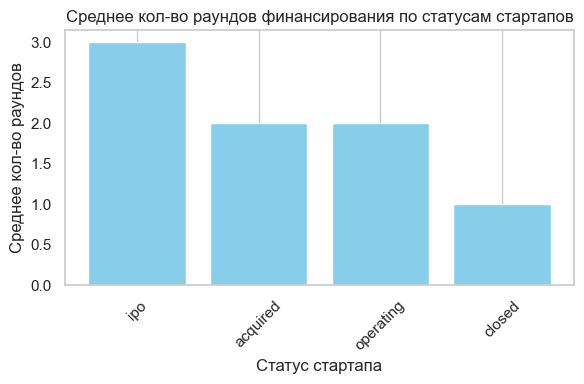

In [62]:
# Построение графика
plt.figure(figsize=(6, 4))
plt.bar(typical_funding_rounds['status'], typical_funding_rounds['funding_rounds'], color='skyblue')
plt.title('Среднее кол-во раундов финансирования по статусам стартапов')
plt.xlabel('Статус стартапа')
plt.ylabel('Среднее кол-во раундов')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

- Стартапы, достигшие стадии IPO, имеют наибольшее среднее количество раундов финансирования.
- Поглощенные стартапы были приобретены на ранних стадиях развития, до прохождения большого количества раундов, это объясняет их меньшее количество раундов.
- У действующих стартапов в среднем ниже количество раундов, что может быть связано с их текущим этапом развития. Многие из них находятся на начальной стадии развития и ещё не успели пройти много раундов финансирования.
- Закрытые стартапы чаще всего проходят меньшее количество раундов финансирования. Это может указывать на то, что такие стартапы не смогли привлечь достаточно инвестиций для дальнейшего развития 
- Поглощенные были приобретены на ранних стадиях развития, до прохождения большого количества раундов.


## Шаг 4. Итоговый вывод и рекомендации

Опишите, что было сделано в проекте, какие были сделаны выводы, подкрепляют ли они друг друга или заставляют сомневаться в полученных результатах.

Так как, датасет был проблемный, включал в себя большое количество дубликатов и пропусков, было принято решение разделить главную таблицу и отформатировали ее. Мы подготовили и проверили датасет данных на соответствие здравого смысла, а также ответили на вопросы заказчика как о предобработке, так и о значении данных для бизнеса:
- Максимальный типичный размер собранных средств в рамках одного раунда был в 2005 году и составил 5.5 млн долларов.
- С увеличением числа раундов финансирования можно предположить, что рынок стал более насыщенным, что могло привести к снижению типичных сумм. Более высокий объем раундов может означать большее количество малых инвестиций, что в свою очередь снижает среднюю сумму.
- Несмотря на рост активности на рынке (количество раундов), типичные суммы финансирования не только не росли, но и снижались в последние годы анализа.
- В ходе работы выявили, что в малых компаниях (с численностью от 1 до 5 сотрудников) доля работников без данных об образовании значительно выше, чем в средних и крупных организациях.
- Среднее значение общего финансирования составляет порядка 4.59 млн.
- На основании анализа данных, выявлили что наиболее высокие типичные цены наблюдаются в категории полупроводников, что может свидетельствовать о высоких затратах на исследования и разработки в этой области. Наибольший разброс наблюдается также в категории полупроводников, что может указывать на значительные колебания в ценах на компоненты или технологии в этой области. 
Выбор категорий из выявленного в ходе анализа топа обусловлен их высокими значениями как типичной суммы привлеченных средств, так и разбросом цен. Инвесторы могут получить значительную прибыль от успешных стартапов в этих категориях.


<a id="results"></a>

[В начало](#start)